# Import moduls

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

# moduls for KMeans_color()
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

# modul for check_silhouette()
from sklearn.metrics import silhouette_score, silhouette_samples

# modul for color_identify_distance()
from math import dist

# Functions

In [3]:
def img_preprocessing(img):
    datas = img
    newData = []
    cutoff = 200
    
    # cutoff 
    for item in datas:
        if item[0] >= cutoff and item[1] >= cutoff and item[2] >= cutoff:
            newData.append((255, 255, 255, 0)) # if RGB value is over cutoff, consider as background (white)
        else:
            newData.append(item)  # don't change others
    
    img_pixel = pd.DataFrame(np.array(newData))
    drop_idx = img_pixel[img_pixel[3] == 0].index  # if pixel is transparent, dorp
    img_pixel = img_pixel.drop(drop_idx)
    pixels = img_pixel.drop(columns=[3], axis=1)
    pixels.columns = ['R', 'G', 'B']
    pixels = pixels.reset_index(drop=True)
    
    return pixels

In [4]:
def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [5]:
def hex_to_rgb(color):
    color = color.lstrip('#')
    lv = len(color)
    return tuple(int(color[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [6]:
def KMeans_color(pixels, n_cluster = 0):
    # if the image only contains white color
    # image preprocessing eliminates white pixels, so if the image only has white color, no pixel will remain
    if len(pixels) == 0:
        return (['#FFFFFF'], 0)
    
    if n_cluster == 0:  # if you're not sure about how many colors are in the image, check silhouette score to identify cluster number
        sil = check_silhouette(pixels)
        if len(sil) == 0 or max(sil) < 0.5: # if max silhouette score is lower than 0.5, consider only one color in the image
            number_of_colors = 1
        else:
            sil_max = sil.index(max(sil)) + 2
            number_of_colors = sil.index(max(sil)) + 2
    else:  # if you know how many colors on the image, use the parameter to do the analysis
        number_of_colors = n_cluster
        
    clf = MiniBatchKMeans(n_clusters = number_of_colors, init = 'k-means++', random_state = 10)
    labels = clf.fit_predict(pixels)
    counts = Counter(labels)
    
    center_colors = clf.cluster_centers_
    hex_colors = [rgb_to_hex(center_colors[i]) for i in counts.keys()]

    # clustered pixel number
    pixel_num = []
    for i in counts.values():
        pixel_num.append(i)
        
    return (hex_colors, pixel_num)

In [7]:
def check_silhouette(pixels):
    sil = []
    
    for n in range(2, 12):
        # if the number of pixel is same or smaller than number of cluster
        # Valid values are 2 to n_samples - 1 (inclusive)
        if len(pixels) <= n or len(pixels[pixels.duplicated(['R', 'G', 'B']) == False]) <= n:
            return sil

        clf = MiniBatchKMeans(n_clusters = n, init = 'k-means++', random_state = 10)
        labels = clf.fit_predict(pixels)
        centroid  = clf.cluster_centers_

        score = silhouette_score(pixels, labels, metric='euclidean')
        silhouette_vals = silhouette_samples(pixels, labels)
        sil.append(score)
        
    return sil

In [8]:
# Calculate the Euclidean distance and get the index of the closest color
def color_dist(hex_s, rgbs):
    color_index = []
    
    for i in range(len(hex_s)):
        min_color = 10000
        min_index = 0
        
        for j in range(len(rgbs)):
            distance = dist(hex_to_rgb(hex_s[i]), tuple(rgbs[j]))

            if distance < min_color:
                min_color = distance
                min_index = j
                
        color_index.append(min_index)
            
    return color_index

In [9]:
def color_identify_distance(rgb_data, hex_colors, pixel_num):
    # if the image only contains white color
    # image preprocessing eliminates white pixels, so if the image only has white color, no pixel will remain
    if pixel_num == 0:
        return 9
    
    rgbs = rgb_data[['R', 'G', 'B']].values.tolist()
    c_name = color_dist(hex_colors, rgbs)
    
    # Returns the index of the color with the greatest weight
    c_per = [0] * len(rgbs)
    for i in range(len(c_name)):
        c_per[c_name[i]] +=  pixel_num[i]
        
    return c_per.index(max(c_per))

# Test

In [10]:
X = np.load("./dataset/1100_clothing_img.npy")
y = np.load("./dataset/1100_clothing_color.npy")

In [11]:
rgb_data = pd.read_csv('./colorChart/colorChart_11.csv')

In [12]:
print(X.shape)
print(y.shape)

(1100, 16384, 4)
(1100,)


In [17]:
colors = []
result = []

In [16]:
%%time

for i in range(len(X)):
    img = X[i]
    pixels = img_preprocessing(img = img)
    hex_colors, pixel_num = KMeans_color(pixels, n_cluster = 0)
    identified_color = color_identify_distance(rgb_data, hex_colors, pixel_num)
    
    if len(hex_colors) == 1:
        colors.append(hex_colors[0])
    else:
        colors.append(hex_colors)
    result.append(identified_color)
    
    if (i+1) % 100 == 0:
        print(f"{i+1} images processed")

100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
900 images processed
1000 images processed
1100 images processed
CPU times: total: 21h 18min 44s
Wall time: 8h 56min 31s


In [20]:
KMeans_result = np.array(result)
np.save("./1100_KMeans_result", KMeans_result)

In [25]:
KMeans_sil = np.array(result)
np.save("./1100_KMeans_silhouette_result", KMeans_sil)

array([ 9,  9,  9, ..., 10, 10, 10])

In [33]:
KMeans_sil_color = np.array(colors)
np.save("./1100_KMeans_silhouette_color", KMeans_sil_color)

array([list(['#bae5e7', '#a8dbdc']), list(['#afd4da', '#88bcc5']),
       list(['#b0d4db', '#91c2ca']), ..., list(['#dabc85', '#e5ae09']),
       '#f5d340', '#e2c04c'], dtype=object)

# Check accuracy

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from matplotlib import pyplot as plt

In [44]:
KMeans_result = np.load('./kmeans_img/1100_clothing/1100_KMeans_result.npy')

In [45]:
np.linalg.norm(y-KMeans_result)

102.20078277586722

In [39]:
conf_mx = confusion_matrix(y, result)
conf_mx

array([[50,  0,  0,  0,  0,  0,  0,  7,  0, 43,  0],
       [ 0, 96,  0,  0,  1,  0,  2,  1,  0,  0,  0],
       [19,  0,  7,  0,  0,  0,  0, 65,  0,  9,  0],
       [ 0,  0,  0, 54,  0,  0, 11,  0, 28,  7,  0],
       [ 1,  5,  0,  0, 84,  2,  1,  1,  0,  4,  2],
       [ 3,  0,  0,  0,  9,  7,  0,  0,  0, 19, 62],
       [ 0,  2,  0,  0,  0,  0, 98,  0,  0,  0,  0],
       [ 6, 11,  4,  0,  0,  0,  0, 77,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  0, 48,  0, 52,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  6,  3,  0, 87,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 89]], dtype=int64)

In [40]:
label = ['aqua','black', 'blue', 'fuchsia', 'green', 'lime', 'maroon', 'navy', 'red', 'white', 'yellow']

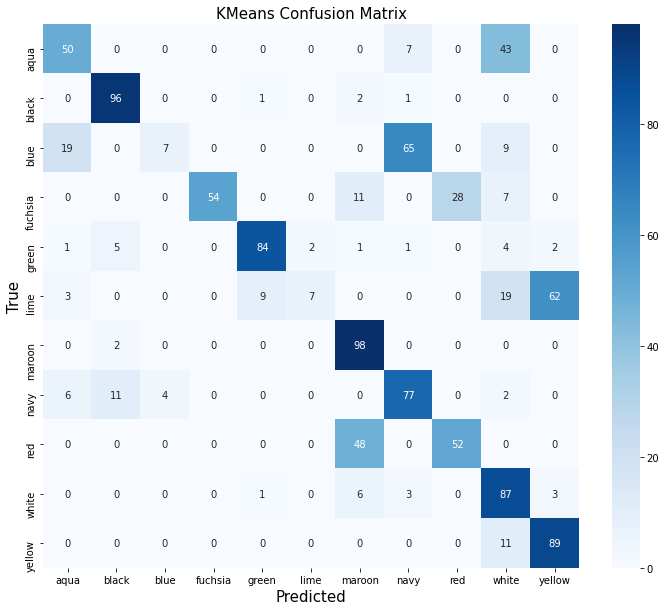

In [41]:
plt.figure(figsize=(12, 10)) 
sns.heatmap(conf_mx, annot=True, cmap=plt.cm.Blues, fmt='d')
plt.xticks(np.arange(0.5, len(label), 1), labels=label)
plt.yticks(np.arange(0.5, len(label), 1), labels=label)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('KMeans Confusion Matrix', fontsize=15)
plt.savefig('KMeans_confusion_matrix.png')
plt.show()

In [28]:
accuracy_score(y, result)

0.6372727272727273

In [29]:
print(classification_report(y, result))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       100
           1       0.84      0.96      0.90       100
           2       0.64      0.07      0.13       100
           3       1.00      0.54      0.70       100
           4       0.88      0.84      0.86       100
           5       0.78      0.07      0.13       100
           6       0.59      0.98      0.74       100
           7       0.50      0.77      0.61       100
           8       0.65      0.52      0.58       100
           9       0.48      0.87      0.62       100
          10       0.57      0.89      0.70       100

    accuracy                           0.64      1100
   macro avg       0.69      0.64      0.59      1100
weighted avg       0.69      0.64      0.59      1100

